# Stock Prediction

The task is to predict the price direction of the stock: whether it will be higher or lower than the price of the previous day. If we predict it to be higher, we might as well buy some stocks, else, we should probably sell. Therefore, the target would be a binary classification of whether the following day closing price will be higher than the opening price.

In [165]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import tensorflow as tf



In [166]:
# Load the training set
df_train = pd.read_csv("AMZN_train.csv")
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


# Data Exploration

* Define a function to run basic analysis on a set of data.
* Apply the function to each of our datasets.
* Observe trends and the validity of our data.

In [167]:
# Define a function to run some basic analysis of our data so that we dont have to repeat our code for each dataset
def analyse(dataframe):
    """Runs an exploration analysis of the dataframe."""
    print("Shape", dataframe.shape, "\n")
    print("Columns", dataframe.columns, "\n")
    dataframe.info()
    print("\n", dataframe.describe(), "\n")
    print("The data ranges from", dataframe["Date"].min(), "to", dataframe["Date"].max())
    dataframe.plot(x="Date", y=["Close", "Open", "High", "Low"])

Shape (4781, 7) 

Columns Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4781 entries, 0 to 4780
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4781 non-null   object 
 1   Open       4781 non-null   float64
 2   High       4781 non-null   float64
 3   Low        4781 non-null   float64
 4   Close      4781 non-null   float64
 5   Adj Close  4781 non-null   float64
 6   Volume     4781 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 261.6+ KB

               Open         High          Low        Close    Adj Close  \
count  4781.000000  4781.000000  4781.000000  4781.000000  4781.000000   
mean    127.619845   129.480122   125.697925   127.662449   127.662449   
std     145.693083   147.132537   144.053633   145.677581   145.677581   
min       1.406250     1.447917     1.312500     1.395833

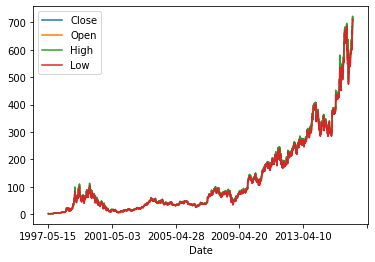

In [168]:
analyse(df_train)

* All prices are very close to each other since the lines are overlapping nearly everywhere. 
* Price has grown significantly over the years, starting at around $100 at the beginning of the century, rising to almost \$700 only 13 years later.

Shape (503, 7) 

Columns Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       503 non-null    object 
 1   Open       503 non-null    float64
 2   High       503 non-null    float64
 3   Low        503 non-null    float64
 4   Close      503 non-null    float64
 5   Adj Close  503 non-null    float64
 6   Volume     503 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 27.6+ KB

               Open         High          Low        Close    Adj Close  \
count   503.000000   503.000000   503.000000   503.000000   503.000000   
mean    992.201292   999.898131   982.574513   991.828966   991.828966   
std     255.496588   259.220381   250.100614   254.885469   254.885469   
min     689.559998   696.820007   682.119995   691.359985   6

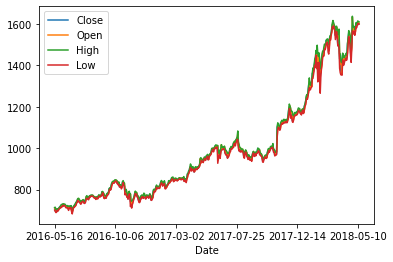

In [169]:
# Read and analyse validation set
df_val = pd.read_csv("AMZN_val.csv")
analyse(df_val)

* The validation set has the same properties as the training set: no null values, clear column types and a valid date range. The stocks have continued to grow in this period.

Shape (504, 7) 

Columns Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       504 non-null    object 
 1   Open       504 non-null    float64
 2   High       504 non-null    float64
 3   Low        504 non-null    float64
 4   Close      504 non-null    float64
 5   Adj Close  504 non-null    float64
 6   Volume     504 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 27.7+ KB

               Open         High          Low        Close    Adj Close  \
count   504.000000   504.000000   504.000000   504.000000   504.000000   
mean   1823.927758  1843.069246  1803.067065  1824.040536  1824.040536   
std     178.129809   179.294163   177.457741   178.470078   178.470078   
min    1346.000000  1396.030029  1307.000000  1343.959961  13

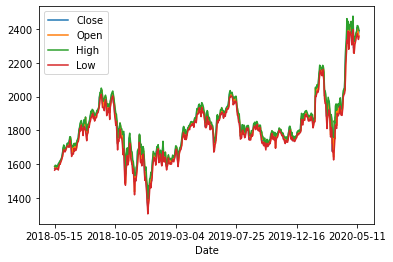

In [170]:
# Read and analyse test set
df_test = pd.read_csv("AMZN_test.csv")
analyse(df_test)

* The test set has the same properties as the validation set but also displays some volatility during this time period.

# Data Preprocessing

* Sort all datasets by date.
* Create dependant/target variable.
* Observe the distribution of the target variable across all datasets.

In [171]:
# Ensuring that the data is sorted by date
df_train.sort_values(by="Date", inplace=True)
df_val.sort_values(by="Date", inplace=True)
df_test.sort_values(by="Date", inplace=True)


In [172]:
# Assign a binary label to each row which is determined by comparing the difference between the closing and opening prices of the stock
# We also shift by a period of '-1', this takes the next day's price direction for the current day
df_train["Target"] = (df_train["Close"] > df_train["Open"]).shift(periods=-1, fill_value=0).astype(int)

In [173]:
df_train["Target"].value_counts()

1    2392
0    2389
Name: Target, dtype: int64

In [174]:
df_val["Target"] = (df_val["Close"] > df_val["Open"]).shift(periods=-1, fill_value=0).astype(int)
df_val["Target"].value_counts()

0    255
1    248
Name: Target, dtype: int64

In [175]:
df_test["Target"] = (df_test["Close"] > df_test["Open"]).shift(periods=-1, fill_value=0).astype(int)
df_test["Target"].value_counts()

1    255
0    249
Name: Target, dtype: int64

* The distribution of our dependant variable appears consistent throughout all our datasets. 

In [176]:
df_train

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,0
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,0
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,0
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,0
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,0
...,...,...,...,...,...,...,...,...
4776,2016-05-09,673.950012,686.979980,671.409973,679.750000,679.750000,3982200,1
4777,2016-05-10,694.000000,704.549988,693.500000,703.070007,703.070007,6105600,1
4778,2016-05-11,705.789978,719.000000,701.650024,713.229980,713.229980,7338200,1
4779,2016-05-12,717.380005,722.450012,711.510010,717.929993,717.929993,5048200,0


# Feature Engineering

* Create 4 new features that could be used to enhance the accuracy of our predictive model.

* As stock prices can depend on the prices of previous days we want to take into account the values of the last n days so we can indicate possible trends that our predictive model can use.
* To do this we will create 2 new features that contain the rolling average of the price changes from the previous 3 and 7 days.

In [177]:
# Create feature that calculates the rolling average of the price change from the previous 3 days
df_train["Moving_Average_3"] = (df_train["Close"] - df_train["Open"]).rolling(window=3, min_periods=1).mean()
df_val["Moving_Average_3"] = (df_val["Close"] - df_val["Open"]).rolling(window=3, min_periods=1).mean()
df_test["Moving_Average_3"] = (df_test["Close"] - df_test["Open"]).rolling(window=3, min_periods=1).mean()

In [178]:
# Create feature that calculates the rolling average of the price change from the previous 7 days
df_train["Moving_Average_7"] = (df_train["Close"] - df_train["Open"]).rolling(window=7, min_periods=1).mean()
df_val["Moving_Average_7"] = (df_val["Close"] - df_val["Open"]).rolling(window=7, min_periods=1).mean()
df_test["Moving_Average_7"] = (df_test["Close"] - df_test["Open"]).rolling(window=7, min_periods=1).mean()


In [179]:
# Create a feature that contains the current day's price difference
df_train["Today_Direction"] = df_train["Close"] - df_train["Open"]
df_val["Today_Direction"] = df_val["Close"] - df_val["Open"]
df_test["Today_Direction"] = df_test["Close"] - df_test["Open"]

In [180]:
# Create a feature that contains the current day's price range
df_train["Price_Range"] = df_train["High"] - df_train["Low"]
df_val["Price_Range"] = df_val["High"] - df_val["Low"]
df_test["Price_Range"] = df_test["High"] - df_test["Low"]

In [181]:
df_train

,Date,Open,High,Low,Close,Adj Close,Volume,Target,Moving_Average_3,Moving_Average_7,Today_Direction,Price_Range
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,0,-0.479167,-0.479167,-0.479167,0.572917
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,0,-0.359375,-0.359375,-0.239583,0.270834
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,0,-0.256945,-0.256945,-0.052084,0.145833
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,0,-0.128472,-0.216146,-0.093750,0.114583
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,0,-0.118056,-0.214584,-0.208334,0.270833
...,...,...,...,...,...,...,...,...,...,...,...,...
4776,2016-05-09,673.950012,686.979980,671.409973,679.750000,679.750000,3982200,1,3.160014,3.610011,5.799988,15.570007
4777,2016-05-10,694.000000,704.549988,693.500000,703.070007,703.070007,6105600,1,10.923340,5.821437,9.070007,11.049988
4778,2016-05-11,705.789978,719.000000,701.650024,713.229980,713.229980,7338200,1,7.436666,4.037153,7.440002,17.349976
4779,2016-05-12,717.380005,722.450012,711.510010,717.929993,717.929993,5048200,0,5.686666,4.978576,0.549988,10.940002


# Classical Machine Learning

* Logistic Regression
* Decision Tree
* Random Forrest
* Gradient Boosting Ensemble

### Logistic Regression

In [182]:
# this is the target column that we aim to predict
y_col = "Target"
# these are the input features for the models
X_cols = [
    "Open",
    "Close",
    "High",
    "Low",
    "Volume",
    "Adj Close",
    "Today_Direction",
    "Price_Range",
    "Moving_Average_3",
    "Moving_Average_7"
]

In [183]:
X_train = df_train[X_cols]
y_train = df_train[y_col]

X_val = df_val[X_cols]
y_val = df_val[y_col]

X_test = df_val[X_cols]
y_test = df_val[y_col]

In [184]:
# for reproducibility
RANDOM_SEED = 42


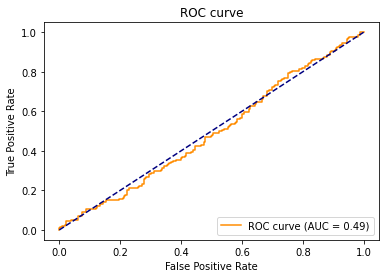

In [185]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scikitplot.metrics import plot_roc_curve

# use default parameters
lr = LogisticRegression()

# fit to train set
lr.fit(X_train, y_train)

# calculate ROC curve and AUC for validation set
y_score = lr.decision_function(X_val)
fpr, tpr, _ = roc_curve(y_val, y_score)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

The AUC value of the logistic regression model is 0.49 meaning that the model is only correct in 49% of its predicitions. This means our model is not a good predictor for this data set.

### Decision Tree

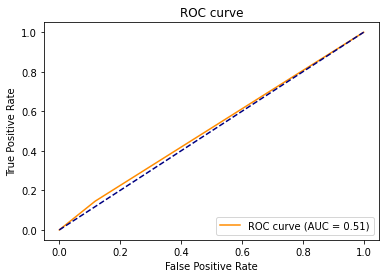

In [186]:
dt = DecisionTreeClassifier(random_state=RANDOM_SEED)

# fit to train set
dt.fit(X_train, y_train)

# calculate ROC curve and AUC for validation set
y_score = dt.predict_proba(X_val)[:, 1] # probability of positive class
fpr, tpr, _ = roc_curve(y_val, y_score)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

The decision tree model has an AUC value of 0.51 which means it is correct for a slight majority of its predictions. This is better than the logistic regression model.

### Random Forrest

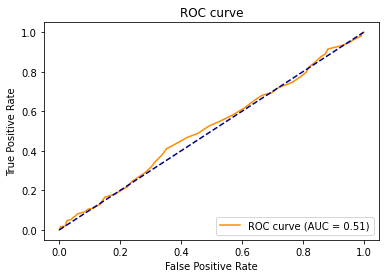

In [187]:
rf = RandomForestClassifier(random_state=RANDOM_SEED)

# fit to train set
rf.fit(X_train, y_train)

# calculate ROC curve and AUC for validation set
y_score = rf.predict_proba(X_val)[:, 1] # probability of positive class
fpr, tpr, _ = roc_curve(y_val, y_score)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

The random forrest preforms at the same level as our decision tree model as they have the same AUC value of 0.51.

### Gradient Boosting Ensemble

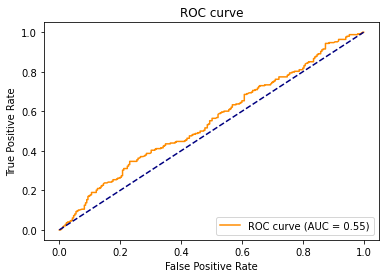

In [188]:
gb = GradientBoostingClassifier(random_state=RANDOM_SEED)

# fit to train set
gb.fit(X_train, y_train)

# calculate ROC curve and AUC for validation set
y_score = gb.predict_proba(X_val)[:, 1] # probability of positive class
fpr, tpr, _ = roc_curve(y_val, y_score)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

The gradient boosting classifier has an AUC value of 0.55 meaning that it is our best preforming model.

# Deep Learning

We are going to use Tensorflow for implementing a small neural network.

In [189]:
# set seed for reproducibility of results
tf.random.set_seed(RANDOM_SEED)

print("Tensorflow version", tf.__version__)


Tensorflow version 2.9.2


We will use Keras to design a small neural network.

In [190]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Normalization(axis=-1),
    tf.keras.layers.Dense(10, input_shape=[X_train.shape[1],], activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'),
    tf.keras.layers.Dropout(0.2, seed=RANDOM_SEED),
    tf.keras.layers.Dense(5, activation="relu", kernel_initializer='random_normal', bias_initializer='zeros'),
    tf.keras.layers.Dense(1, activation="sigmoid", kernel_initializer='random_normal', bias_initializer='zeros')
])

In [191]:
# this configures the model's loss function, weight optimizer, and metrics to keep track of
model.compile(
    loss="binary_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['AUC']
)

We are going to train our model for 50 epochs, and keep track of its loss (binary_crossentropy) and AUC values during each epoch.

To prevent overfitting, we are implementing two callbacks: (1) learning rate scheduler, and (2) early stopping callback.

In [192]:
def learning_rate_scheduler(epoch, learning_rate):
    """Learning rate decay callback."""
    if epoch < 5:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.01)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)

In [193]:
# the model.fit(...) method returns a 'history' object with stats about the training
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    verbose=1,
    callbacks=[early_stopping_callback, learning_rate_callback])

Epoch 1/50
150/150 [==============================] - 2s 13ms/step - loss: 47.1543 - auc: 0.4898 - val_loss: 0.6931 - val_auc: 0.5000 - lr: 0.0010
Epoch 2/50
150/150 [==============================] - 2s 10ms/step - loss: 1.1417 - auc: 0.4985 - val_loss: 0.6931 - val_auc: 0.5000 - lr: 0.0010
Epoch 3/50
150/150 [==============================] - 2s 10ms/step - loss: 0.6964 - auc: 0.4973 - val_loss: 0.6931 - val_auc: 0.5000 - lr: 0.0010
Epoch 4/50
150/150 [==============================] - 2s 10ms/step - loss: 0.7008 - auc: 0.4968 - val_loss: 0.6931 - val_auc: 0.5000 - lr: 0.0010
Epoch 5/50
150/150 [==============================] - 2s 10ms/step - loss: 0.7061 - auc: 0.4866 - val_loss: 0.6931 - val_auc: 0.5000 - lr: 0.0010
Epoch 6/50
150/150 [==============================] - 2s 11ms/step - loss: 0.6981 - auc: 0.4917 - val_loss: 0.6931 - val_auc: 0.5000 - lr: 9.9005e-04
Epoch 7/50
150/150 [==============================] - 2s 10ms/step - loss: 0.6947 - auc: 0.4939 - val_loss: 0.6931 - va

We observe that both the training and the validation AUC are very close to 0.5, improving the overall score only over the logistic regression model.

In [194]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 10)               21        
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 5)                 55        
                                                                 
 dense_5 (Dense)             (None, 1)                 6         
                                                                 
Total params: 192
Trainable params: 171
Non-trainable params: 21
_______________________________________________________

Below, we plot the train and validation loss and AUC values as a function of the epoch. We use the matplotlib library, and the history object to do that.

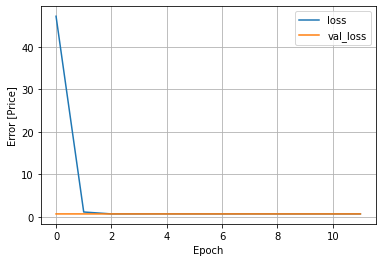

In [195]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [Price]')
plt.legend()
plt.grid(True)

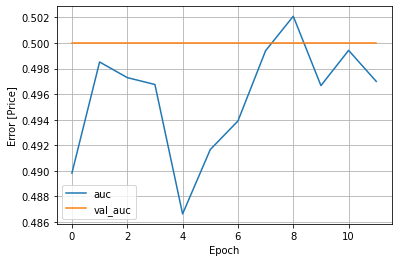

In [196]:
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('Error [Price]')
plt.legend()
plt.grid(True)

# Conclusion

Out of the four classical machine learning models and one neural network formed, the best preforming model was the gradient boosting classifier.

Below we will evaluate the preformance of the Gradient Boosting Classifier on the test set as well as plotting the feature importances of the model.

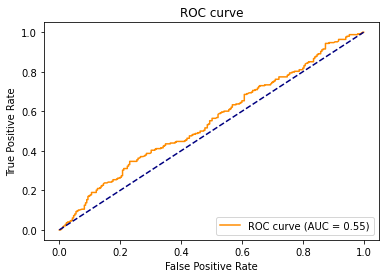

In [197]:
gb = GradientBoostingClassifier(random_state=RANDOM_SEED)

# fit to train set
gb.fit(X_train, y_train)

# calculate ROC curve and AUC for test set
y_score = gb.predict_proba(X_test)[:, 1] # probability of positive class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

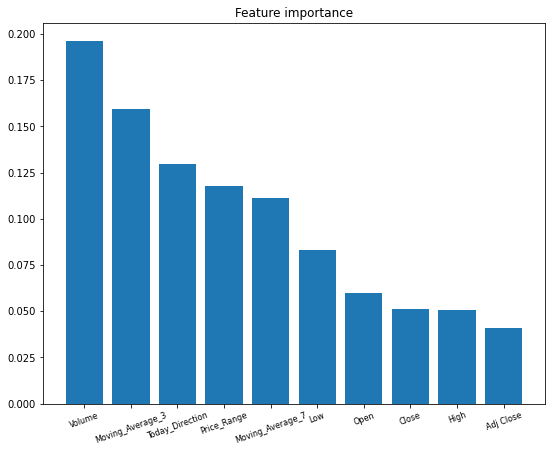

In [198]:
import numpy as np
# Calculate feature importances
importances = gb.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [df_train[X_cols].columns[i] for i in indices]

_ = plt.figure(figsize=(9, 7))
plt.bar(names, importances[indices])
_ = plt.title("Feature importance")
_ = plt.xticks(rotation=20, fontsize = 8)